In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import numpy.random as rnd
import torch
import torch.nn as nn
import torch.optim as optim
import math
import mat73
import matplotlib.pyplot as plt


# setting up GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [71]:
import h5py
import numpy as np


file_path = 'b3_hand_imagine_alpha_day10.mat'

# load data
with h5py.File(file_path, 'r') as mat_file:
    x = np.array(mat_file['x'])  
    y = np.array(mat_file['y']) 

print("X shape:", x.shape)
print("Y shape:", y.shape)


X shape: (2448, 1, 400, 23, 11)
Y shape: (2448, 1, 400, 23, 11)


In [3]:
x.shape

(2448, 1, 400, 23, 11)

In [72]:
# transform shape -- to trial*channel*f1*f2*time
x = x.transpose(0, 1, 4, 3, 2)
y = y.transpose(0, 1, 4, 3, 2)

print("X shape:", x.shape)
print("Y shape:", y.shape)

X shape: (2448, 1, 11, 23, 400)
Y shape: (2448, 1, 11, 23, 400)


In [ ]:
# import numpy as np

# # Define parameters for the synthetic dataset
# trial = 1000
# channel = 1
# frame1 = 11
# frame2 = 23
# time = 400

# # Frequency, amplitude, and phase parameters for cosine signals
# frequencies = np.random.uniform(0.01, 0.1, (frame1, frame2))  # Different frequencies for each feature
# amplitudes = np.random.uniform(0.5, 1.5, (frame1, frame2))    # Different amplitudes for each feature
# phases = np.random.uniform(0, 2 * np.pi, (frame1, frame2))    # Different phases for each feature

# # Generate x as a cosine signal with given parameters for each feature
# x = np.zeros((trial, channel, frame1, frame2, time))
# for i in range(frame1):
#     for j in range(frame2):
#         t = np.arange(time)
#         x[:, 0, i, j, :] = amplitudes[i, j] * np.cos(2 * np.pi * frequencies[i, j] * t + phases[i, j])

# # Generate y as x shifted by one time step (x(t+1))
# y = np.roll(x, shift=-1, axis=-1)

# # Display shapes to confirm the structure
# x.shape, y.shape


((1000, 1, 11, 23, 400), (1000, 1, 11, 23, 400))

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the Encoder network with updated input shapes
class Encoder3D(nn.Module):
    def __init__(self):
        super(Encoder3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=(1, 1, 2), padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=(1, 1, 2), padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, stride=(1, 1, 2), padding=1)
        self.fc = nn.Linear(64 * 11 * 23 * 50, 128)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define the Decoder network to reconstruct the original shape
class Decoder3D(nn.Module):
    def __init__(self):
        super(Decoder3D, self).__init__()
        self.fc = nn.Linear(128, 64 * 11 * 23 * 50)
        self.deconv1 = nn.ConvTranspose3d(64, 32, kernel_size=3, stride=(1, 1, 2), padding=1, output_padding=(0, 0, 1))
        self.deconv2 = nn.ConvTranspose3d(32, 16, kernel_size=3, stride=(1, 1, 2), padding=1, output_padding=(0, 0, 1))
        self.deconv3 = nn.ConvTranspose3d(16, 1, kernel_size=3, stride=(1, 1, 2), padding=1, output_padding=(0, 0, 1))

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 11, 23, 50)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))  # Use tanh for output within [-1, 1] range
        return x

# Initialize the models
encoder = Encoder3D().to(device)
decoder = Decoder3D().to(device)

# Define the autoencoder pipeline
class Autoencoder3D(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder3D, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder3D(encoder, decoder).to(device)

# Convert data to PyTorch tensors and create a dataset
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(x_tensor, y_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses = []
val_losses = []

# Training loop with early stopping
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = autoencoder(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Record training loss

    # Validation phase
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = autoencoder(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Record validation loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model = autoencoder.state_dict()  # Save the best model state
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        autoencoder.load_state_dict(best_model)  # Load the best model
        break


Using device: cuda
Epoch [1/100], Train Loss: 0.1536, Val Loss: 0.1403
Epoch [2/100], Train Loss: 0.1253, Val Loss: 0.0921
Epoch [3/100], Train Loss: 0.0758, Val Loss: 0.0600
Epoch [4/100], Train Loss: 0.0535, Val Loss: 0.0458
Epoch [5/100], Train Loss: 0.0418, Val Loss: 0.0371
Epoch [6/100], Train Loss: 0.0344, Val Loss: 0.0322
Epoch [7/100], Train Loss: 0.0295, Val Loss: 0.0279
Epoch [8/100], Train Loss: 0.0257, Val Loss: 0.0252
Epoch [9/100], Train Loss: 0.0230, Val Loss: 0.0232
Epoch [10/100], Train Loss: 0.0210, Val Loss: 0.0217
Epoch [11/100], Train Loss: 0.0193, Val Loss: 0.0213
Epoch [12/100], Train Loss: 0.0181, Val Loss: 0.0200
Epoch [13/100], Train Loss: 0.0167, Val Loss: 0.0199
Epoch [14/100], Train Loss: 0.0157, Val Loss: 0.0188
Epoch [15/100], Train Loss: 0.0148, Val Loss: 0.0189
Epoch [16/100], Train Loss: 0.0140, Val Loss: 0.0184
Epoch [17/100], Train Loss: 0.0134, Val Loss: 0.0185
Epoch [18/100], Train Loss: 0.0128, Val Loss: 0.0187
Epoch [19/100], Train Loss: 0.0124, 

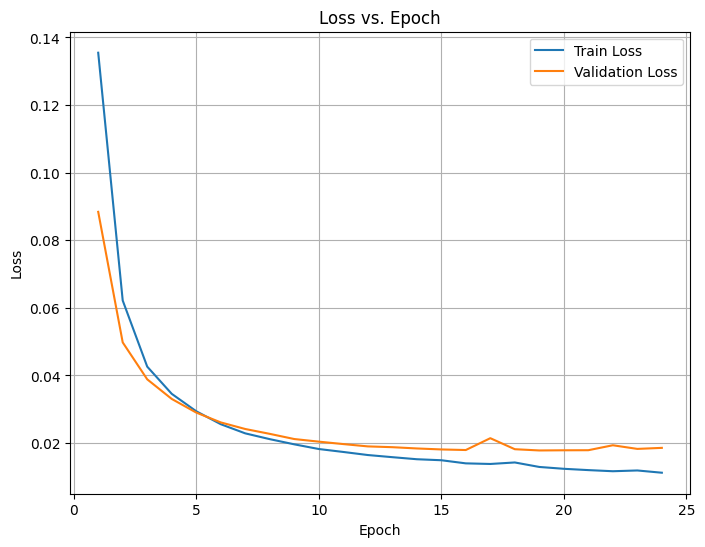

In [89]:
# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
outputs.shape

torch.Size([8, 1, 1, 1, 400])

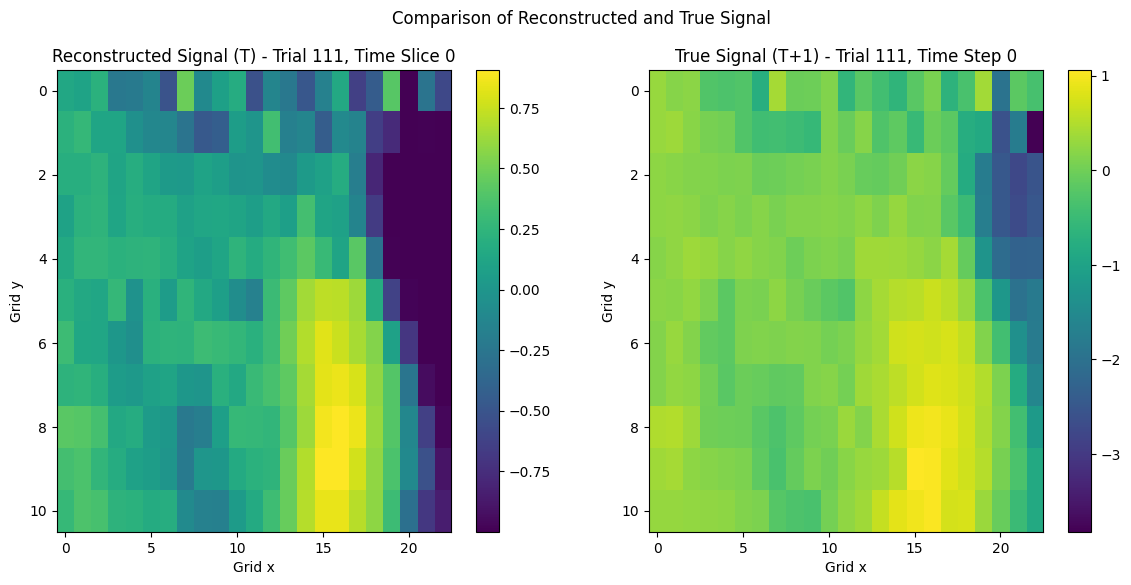

In [90]:
import matplotlib.pyplot as plt

# Select the trial for visualization
trial_index = 111  # Adjust the index as needed

# Set the model to evaluation mode
autoencoder.eval()

# Extract the trial from the data
x_trial = x_tensor[trial_index].unsqueeze(0).to(device)  # Add batch dimension
y_trial = y_tensor[trial_index].cpu().numpy()  # Convert target trial to numpy for plotting

# Get the reconstructed output
with torch.no_grad():
    reconstructed_trial = autoencoder(x_trial).cpu().numpy().squeeze()  # Remove batch dimension

# Plot using imshow (heatmap representation similar to imagesc)
# Here, we visualize a specific time slice (e.g., the first time slice) across frames
time_slice = 0

plt.figure(figsize=(14, 6))

# Reconstructed Signal
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_trial[:, :, time_slice], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title(f"Reconstructed Signal (T) - Trial {trial_index}, Time Slice {time_slice}")
plt.xlabel("Grid x")
plt.ylabel("Grid y")

# True Signal
plt.subplot(1, 2, 2)
plt.imshow(y_trial[0,:, :, time_slice], aspect='auto', cmap='viridis')
plt.colorbar()
plt.title(f"True Signal (T+1) - Trial {trial_index}, Time Step {time_slice}")
plt.xlabel("Grid x")
plt.ylabel("Grid y")

plt.suptitle("Comparison of Reconstructed and True Signal")
plt.show()


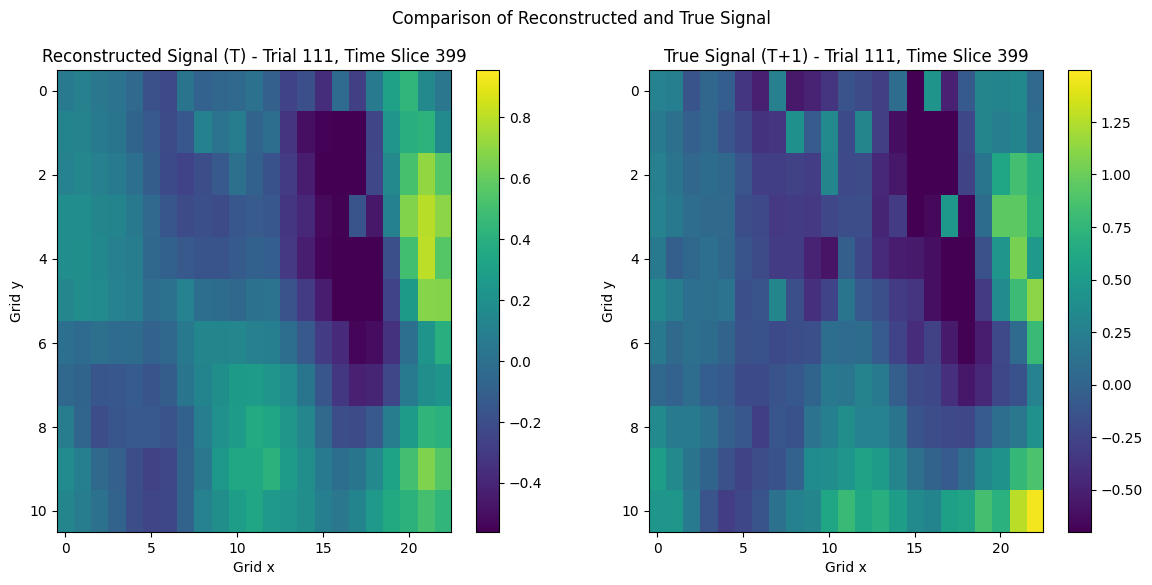

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import torch

# Select a specific trial
trial_index = 111  # Change this to select a different trial
x_trial = x_tensor[trial_index].unsqueeze(0).to(device)  # Add batch dimension
y_trial = y_tensor[trial_index].cpu().numpy()  # Convert target trial to numpy

# Get the reconstructed output
autoencoder.eval()
with torch.no_grad():
    reconstructed_trial = autoencoder(x_trial).cpu().numpy().squeeze()  # Remove batch dimension

# Assume the shape of reconstructed_trial and y_trial is (11, 23, time_steps)
time_steps = reconstructed_trial.shape[2]

# Set up the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
cax1 = axs[0].imshow(reconstructed_trial[:, :, 0], cmap='viridis', aspect='auto')
cax2 = axs[1].imshow(y_trial[0, :, :, 0], cmap='viridis', aspect='auto')

# Add colorbars
fig.colorbar(cax1, ax=axs[0])
fig.colorbar(cax2, ax=axs[1])

# Set titles and labels
axs[0].set_title(f"Reconstructed Signal (T) - Trial {trial_index}, Time Slice 0")
axs[0].set_xlabel("Grid x")
axs[0].set_ylabel("Grid y")

axs[1].set_title(f"True Signal (T+1) - Trial {trial_index}, Time Slice 0")
axs[1].set_xlabel("Grid x")
axs[1].set_ylabel("Grid y")

fig.suptitle("Comparison of Reconstructed and True Signal")

# Update function for animation
def update(frame):
    cax1.set_array(reconstructed_trial[:, :, frame])
    axs[0].set_title(f"Reconstructed Signal (T) - Trial {trial_index}, Time Slice {frame}")
    
    cax2.set_array(y_trial[0, :, :, frame])
    axs[1].set_title(f"True Signal (T+1) - Trial {trial_index}, Time Slice {frame}")
    return cax1, cax2

# Create animation
ani = FuncAnimation(fig, update, frames=time_steps, interval=50, blit=False)

# Save animation as a video (MP4 format)
ani.save("reconstruction_true.mp4", writer='ffmpeg', fps=20)

# Display the animation (for environments that support it directly)
plt.show()


In [65]:
activations['conv1'].shape

torch.Size([1, 16, 11, 23, 200])

In [67]:
activation = activations[layer_name].squeeze(0)
activation.shape

torch.Size([16, 11, 23, 200])

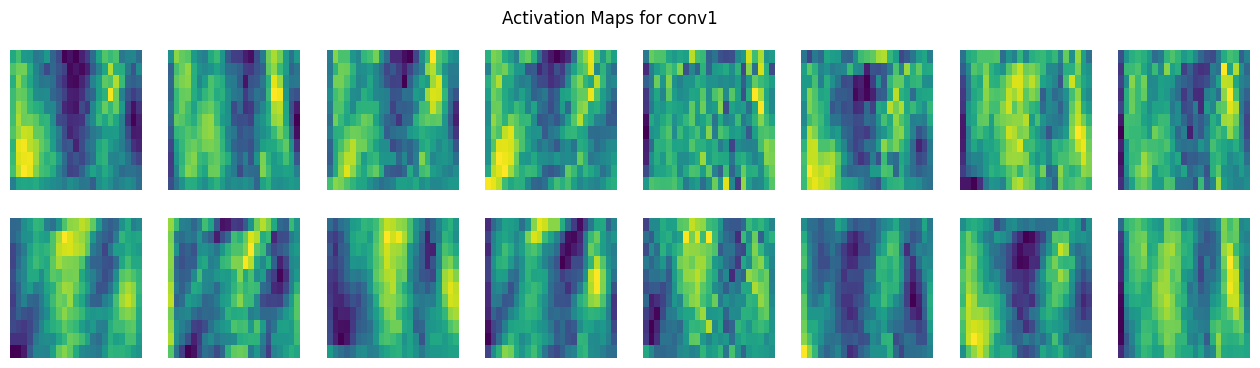

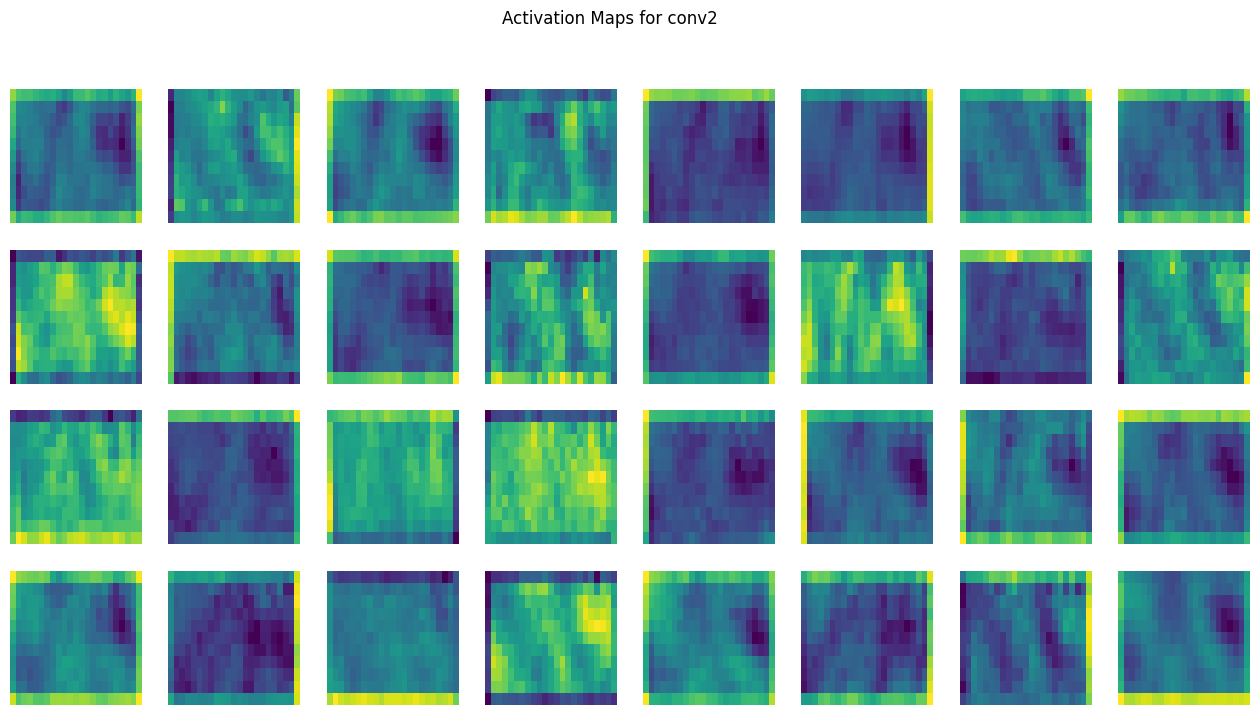

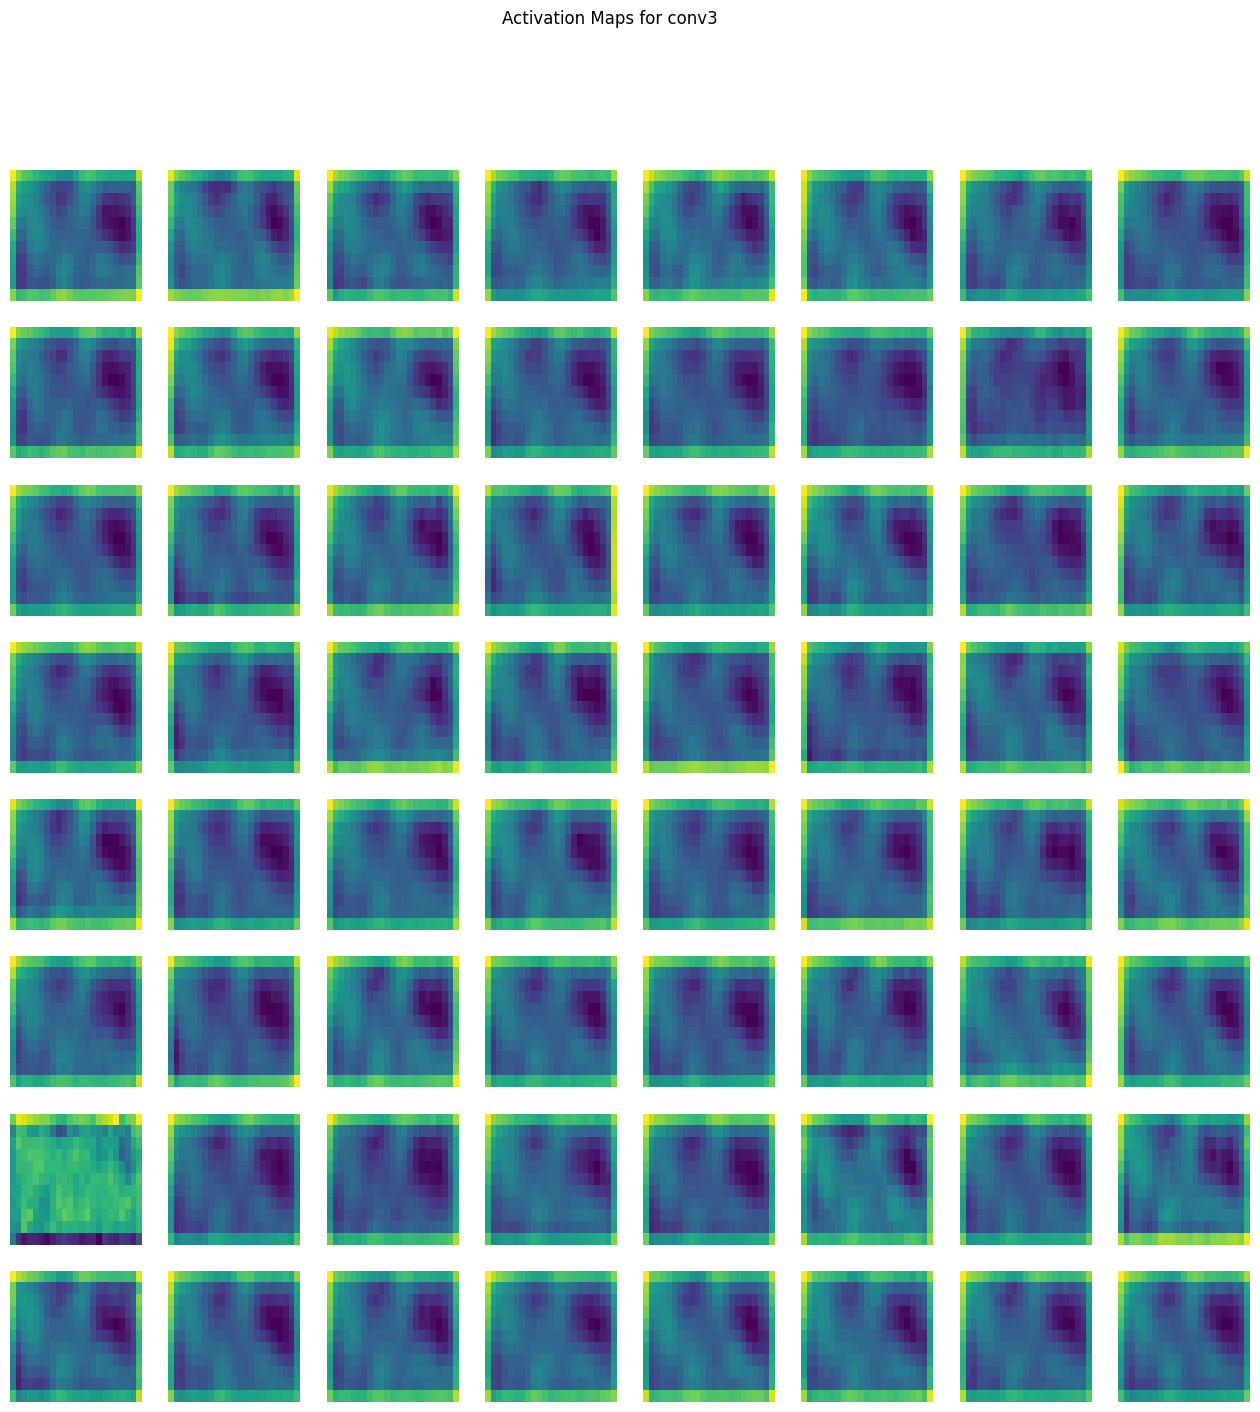

In [116]:
import matplotlib.pyplot as plt

# Select a sample input from the validation dataset
sample_x, _ = val_dataset[0]  # Take the first example from validation set
sample_x = sample_x.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Dictionary to store activations from each layer
activations = {}

# Define a hook function to capture the output of each layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()  # Store activation and move to CPU
    return hook

# Register hooks for each convolutional layer in the encoder
encoder.conv1.register_forward_hook(get_activation("conv1"))
encoder.conv2.register_forward_hook(get_activation("conv2"))
encoder.conv3.register_forward_hook(get_activation("conv3"))

# Perform a forward pass to get activations
with torch.no_grad():
    _ = autoencoder.encoder(sample_x)

# Function to visualize the activation maps
def plot_activations(activations, layer_name, n_cols=8):
    activation = activations[layer_name].squeeze(0)  # Remove batch dimension
    n_filters = activation.size(0)
    n_rows = (n_filters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(f"Activation Maps for {layer_name}")
    for i in range(n_filters):
        row, col = divmod(i, n_cols)
        ax = axes[row, col]
        ax.imshow(activation[i].mean(dim=-1), cmap="viridis", aspect="auto")  # Averaging over time for 2D visualization
        ax.axis("off")
    plt.show()

# Visualize activations for each convolutional layer
plot_activations(activations, "conv1")
plot_activations(activations, "conv2")
plot_activations(activations, "conv3")


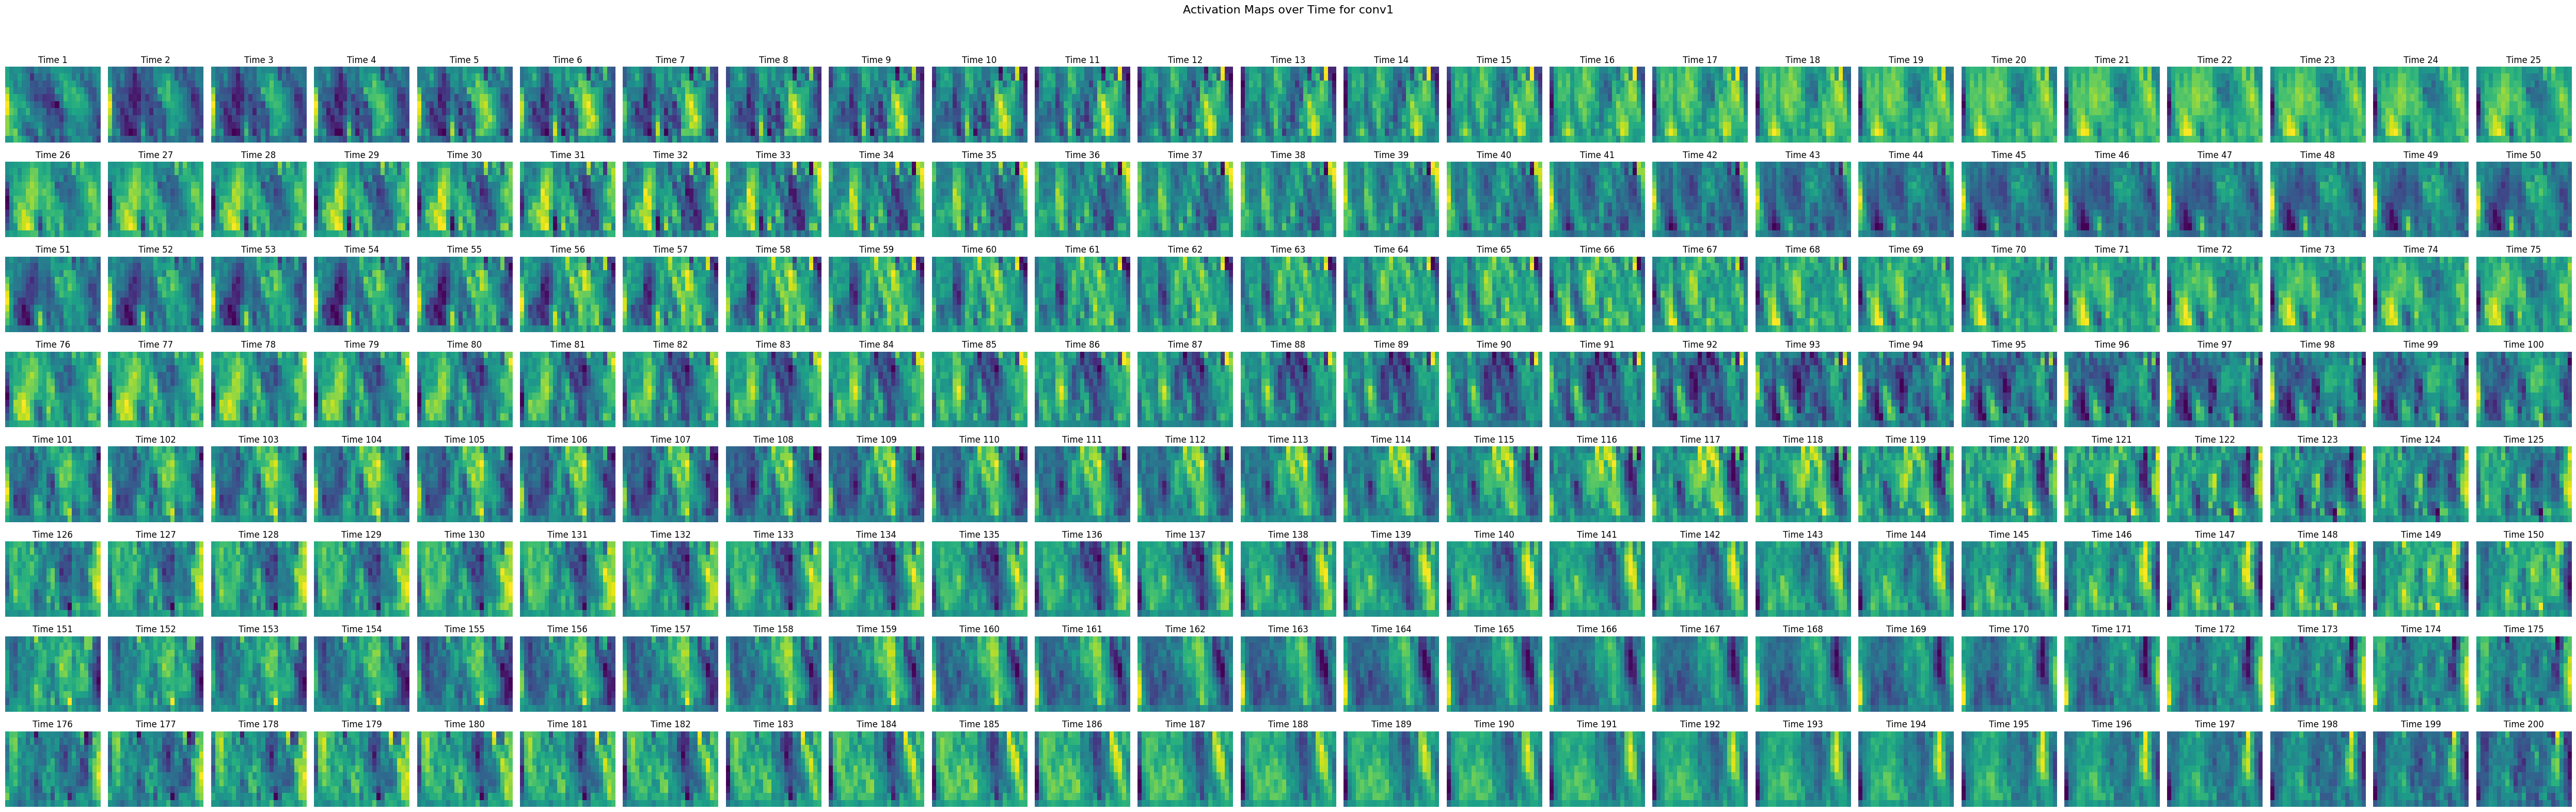

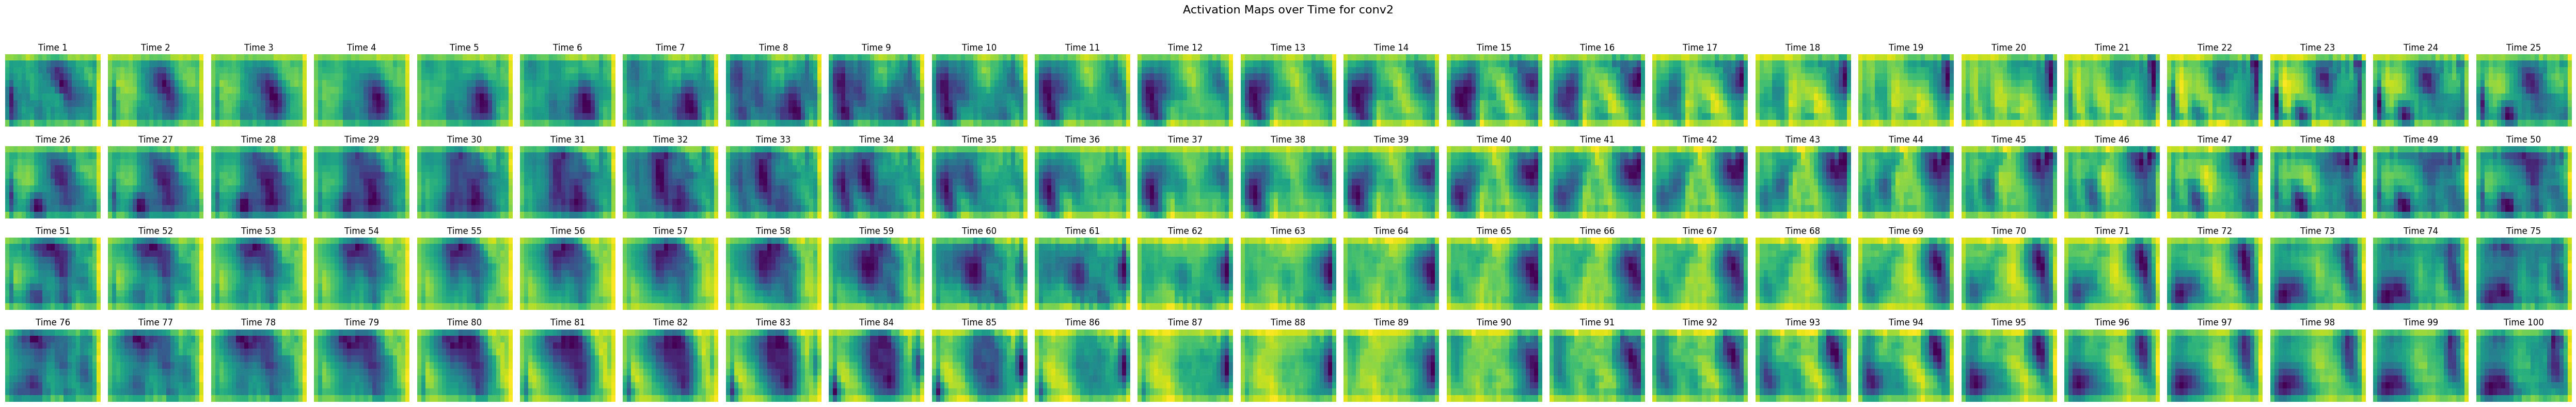

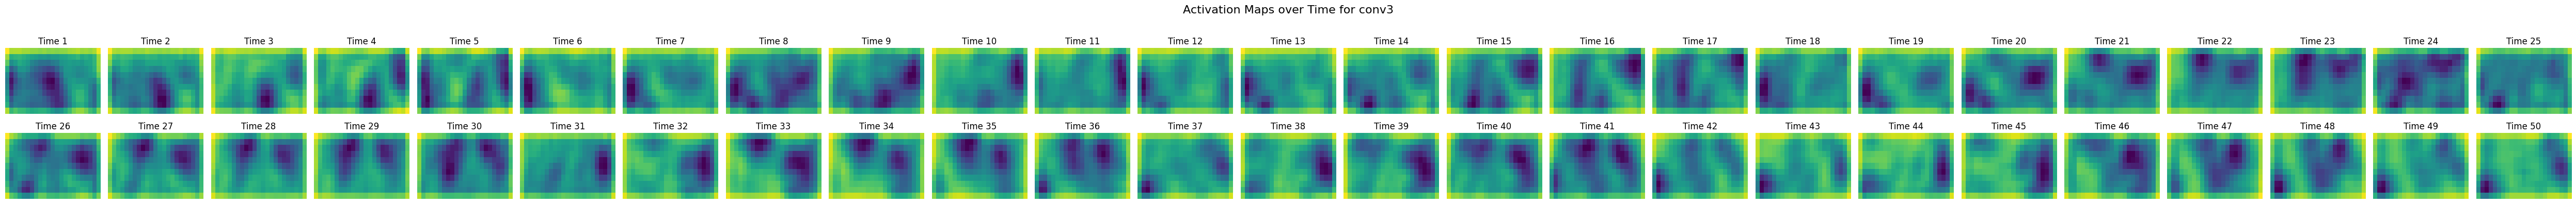

In [136]:
import matplotlib.pyplot as plt
import math

# Function to visualize activation maps over time in a 2D grid layout
def plot_activations_2d(activations, layer_name, n_cols=25):
    activation = activations[layer_name].squeeze(0)  # Remove batch dimension
    n_time = activation.size(-1)  # Number of time points

    # Calculate the number of rows and columns for the grid
    n_rows = math.ceil(n_time / n_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(f"Activation Maps over Time for {layer_name}", fontsize=16)

    for t in range(n_time):
        # Calculate the row and column index in the grid
        row, col = divmod(t, n_cols)
        averaged_activation = activation[:, :, :, t].mean(dim=0)  # Average across channels

        ax = axes[row, col]
        ax.imshow(averaged_activation, cmap="viridis", aspect="auto")  # Plot averaged activation
        ax.set_title(f"Time {t+1}")
        ax.axis("off")

    # Turn off unused subplots
    for i in range(n_time, n_rows * n_cols):
        row, col = divmod(i, n_cols)
        axes[row, col].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Visualize activations for each convolutional layer in a 2D grid
plot_activations_2d(activations, "conv1")
plot_activations_2d(activations, "conv2")
plot_activations_2d(activations, "conv3")


In [118]:
# backup model
encoder_backup = encoder
decoder_backup = decoder

autoencoder_backup = autoencoder

In [124]:
del encoder, autoencoder, decoder 
encoder = encoder_backup
decoder = decoder_backup
autoencoder = autoencoder_backup

In [140]:
# grad cam
# Hook storage
feature_maps = None
gradients = None

# Forward hook
def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output

# Backward hook
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Register hooks on conv3
forward_hook_handle = encoder.conv3.register_forward_hook(forward_hook)
backward_hook_handle = encoder.conv3.register_backward_hook(backward_hook)



def generate_heatmap(input_data, model, target_index=None):
    global feature_maps, gradients
    model.eval()

    # Forward pass
    input_data = input_data.to(device)
    output = model(input_data)

    # If a specific target index is required, select it
    if target_index is not None:
        output = output[:, target_index]

    # Backward pass
    model.zero_grad()
    output.backward(torch.ones_like(output))

    # Grad-CAM heatmap computation
    # gradients - (batch, C, H, W, T)
    weights = torch.mean(gradients, dim=(2, 3, 4))  # Average gradients spatially and temporally - (1 * C)

    # feature_maps - conv activation map
    heatmap = torch.sum(weights[:, :, None, None, None] * feature_maps, dim=1)  # Weighted sum - each channel block * its weights 
    heatmap = torch.relu(heatmap)  # ReLU to retain only positive influences - (1, H, W, T)

    # Normalize the heatmap to [0, 1]
    heatmap = heatmap - heatmap.min()
    heatmap = heatmap / heatmap.max()
    
    return heatmap

import matplotlib.pyplot as plt

# Example: Plotting slices of the heatmap
sample_x, _ = val_dataset[0]  # Take the first example from validation set
sample_x = sample_x.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

heatmap = generate_heatmap(sample_x, encoder)
heatmap = heatmap.cpu().detach().numpy()
forward_hook_handle.remove()
backward_hook_handle.remove()

d:\anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


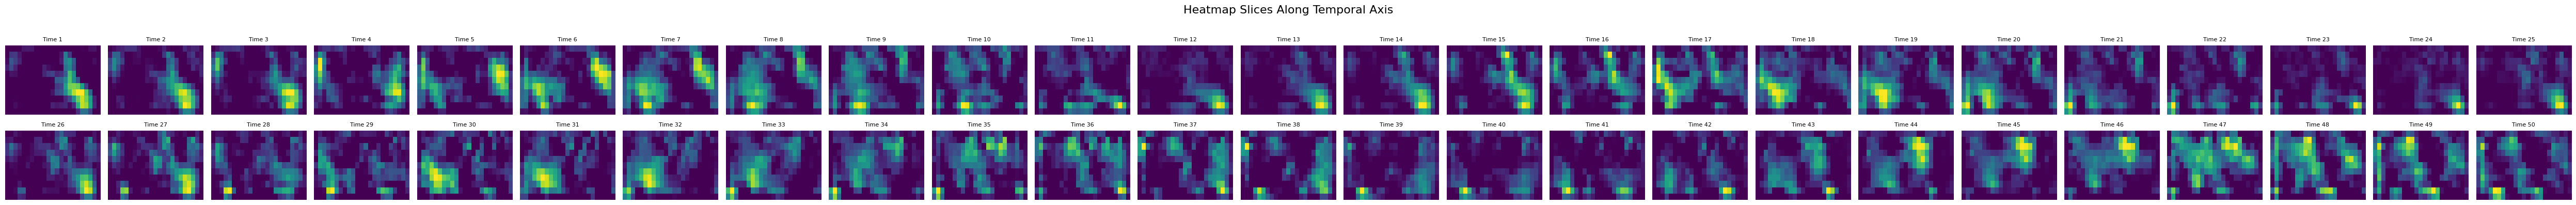

In [145]:
import math
import matplotlib.pyplot as plt

# Function to visualize heatmap slices in a 2D grid layout
def plot_heatmap_slices(heatmap, n_cols=25):
    """
    Visualizes heatmap slices along the temporal axis in a 2D grid layout.

    Parameters:
        heatmap (torch.Tensor or np.ndarray): The heatmap with shape (batch, depth, height, width, time).
        n_cols (int): Number of columns in the grid.
    """
    heatmap = heatmap.squeeze(0)  # Remove batch dimension if present
    n_time = heatmap.shape[-1]  # Temporal dimension (number of slices)

    # Calculate the number of rows and columns for the grid
    n_rows = math.ceil(n_time / n_cols)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle("Heatmap Slices Along Temporal Axis", fontsize=16)

    for t in range(n_time):
        # Calculate the row and column index in the grid
        row, col = divmod(t, n_cols)
        slice_data = heatmap[:, :, t]  # Extract the 2D slice for this time point
    
        ax = axes[row, col]
        ax.imshow(slice_data, cmap="viridis", aspect="auto")  # Plot the heatmap slice
        ax.set_title(f"Time {t+1}", fontsize=8)
        ax.axis("off")

    # Turn off unused subplots
    for i in range(n_time, n_rows * n_cols):
        row, col = divmod(i, n_cols)
        axes[row, col].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


# Assuming heatmap is of shape (batch, depth, height, width, time)
plot_heatmap_slices(heatmap, n_cols=25)



In [174]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_heatmap(heatmap):
    """
    Visualize a 3D volumetric heatmap with a bounding box and top 50% values.

    Parameters:
    - heatmap: np.ndarray or torch.Tensor, shape (1, H, W, T)
    """
    heatmap = heatmap.squeeze(0)  # Remove batch dimension, resulting in shape (H, W, T)
    H, W, T = heatmap.shape

    # Create the 3D grid
    x, y, z = np.meshgrid(np.arange(W), np.arange(H), np.arange(T))

    # Normalize heatmap values
    heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    values = heatmap_normalized.flatten()

    # Select top 50% points based on heatmap values
    threshold = np.percentile(values, 90)  # Calculate the 50th percentile
    mask = values >= threshold  # Mask for values above threshold
    x, y, z, values = x.flatten()[mask], y.flatten()[mask], z.flatten()[mask], values[mask]

    # Create the plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Draw the bounding box
    for i in range(2):  # i = 0 for min, i = 1 for max
        ax.plot([0, W-1], [0, 0], [i*(T-1), i*(T-1)], color='black')  # Bottom edge
        ax.plot([0, W-1], [H-1, H-1], [i*(T-1), i*(T-1)], color='black')  # Top edge
        ax.plot([0, 0], [0, H-1], [i*(T-1), i*(T-1)], color='black')  # Left edge
        ax.plot([W-1, W-1], [0, H-1], [i*(T-1), i*(T-1)], color='black')  # Right edge

    for j in range(2):  # j = 0 for min, j = 1 for max
        ax.plot([0, 0], [j*(H-1), j*(H-1)], [0, T-1], color='black')  # Left-front edge
        ax.plot([W-1, W-1], [j*(H-1), j*(H-1)], [0, T-1], color='black')  # Right-front edge
        ax.plot([0, 0], [j*(H-1), j*(H-1)], [0, T-1], color='black')  # Left-back edge
        ax.plot([W-1, W-1], [j*(H-1), j*(H-1)], [0, T-1], color='black')  # Right-back edge

    # Scatter plot for top 50% points
    scatter = ax.scatter(x, y, z, c=values, cmap='hot', alpha=0.8)

    # Add a color bar
    fig.colorbar(scatter, ax=ax, label='Heatmap Value')

    # Set labels and title
    ax.set_title("Top 50% Values with Bounding Box")
    ax.set_xlabel("Width (W)")
    ax.set_ylabel("Height (H)")
    ax.set_zlabel("Time (T)")

    plt.show()



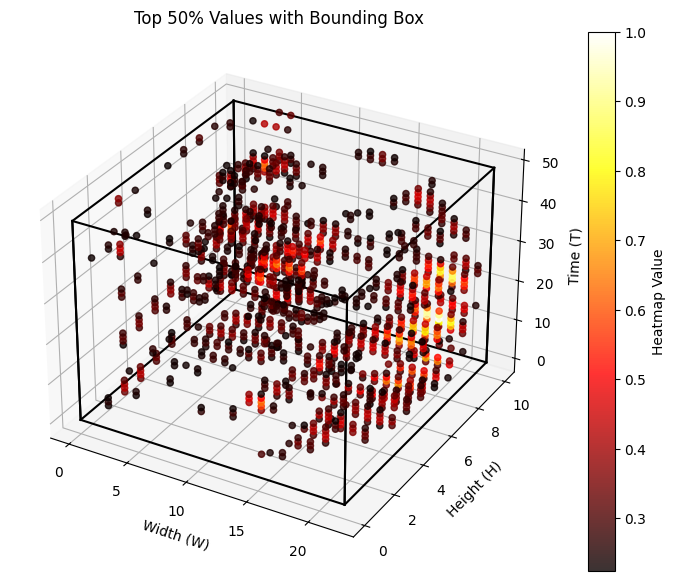

In [175]:
visualize_heatmap(heatmap)

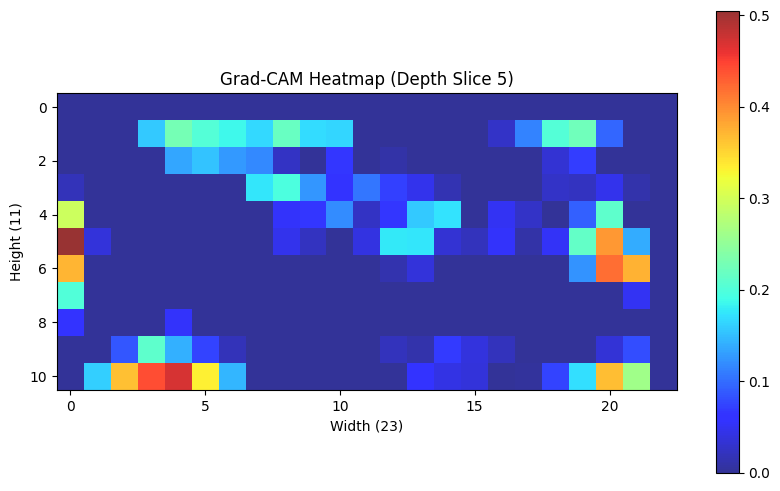

In [35]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Select a sample input from the validation dataset
sample_x, _ = val_dataset[0]  # Take the first example from validation set
sample_x = sample_x.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Hook to store gradients and activations
gradients = {}
activations = {}

def save_gradients(module, grad_in, grad_out):
    """Hook to save gradients from target layer."""
    gradients["value"] = grad_out[0]

def save_activations(module, input, output):
    """Hook to save activations from target layer."""
    activations["value"] = output

# Register hooks for the final convolutional layer (conv3 in the encoder)
encoder.conv3.register_forward_hook(save_activations)
encoder.conv3.register_backward_hook(save_gradients)

# Perform a forward pass to get the output (WITHOUT torch.no_grad())
autoencoder.eval()  # Set model to evaluation mode
output = autoencoder(sample_x)  # Forward pass without disabling gradients

# Compute the target loss (MSE for reconstruction)
loss = F.mse_loss(output, sample_x)

# Backward pass to compute gradients
autoencoder.zero_grad()  # Clear previous gradients
loss.backward()  # Compute gradients


# Get gradients and activations
grads = gradients["value"].cpu().numpy()[0]  # Gradients of shape [channels, depth, height, width]
# Get activations and detach them from the computational graph
acts = activations["value"].detach().cpu().numpy()[0]  # Activations of shape [channels, depth, height, width]


# Compute channel-wise weights using global average pooling of gradients
weights = np.mean(grads, axis=(1, 2, 3))  # Shape: [channels]

# Compute the Grad-CAM map
grad_cam = np.zeros(acts.shape[1:], dtype=np.float32)  # Shape: [depth, height, width]
for i, w in enumerate(weights):
    grad_cam += w * acts[i]  # Weighted sum of activation maps

# Apply ReLU to the Grad-CAM map
grad_cam = np.maximum(grad_cam, 0)

# Normalize the Grad-CAM map for visualization
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

# Visualize the Grad-CAM heatmap for a selected depth slice
depth_slice = 5  # Change this to visualize a valid slice
plt.figure(figsize=(10, 6))
plt.imshow(grad_cam[:, :, depth_slice], cmap="jet", alpha=0.8)
plt.colorbar()
plt.title(f"Grad-CAM Heatmap (Depth Slice {depth_slice})")
plt.xlabel("Width (23)")
plt.ylabel("Height (11)")
plt.show()


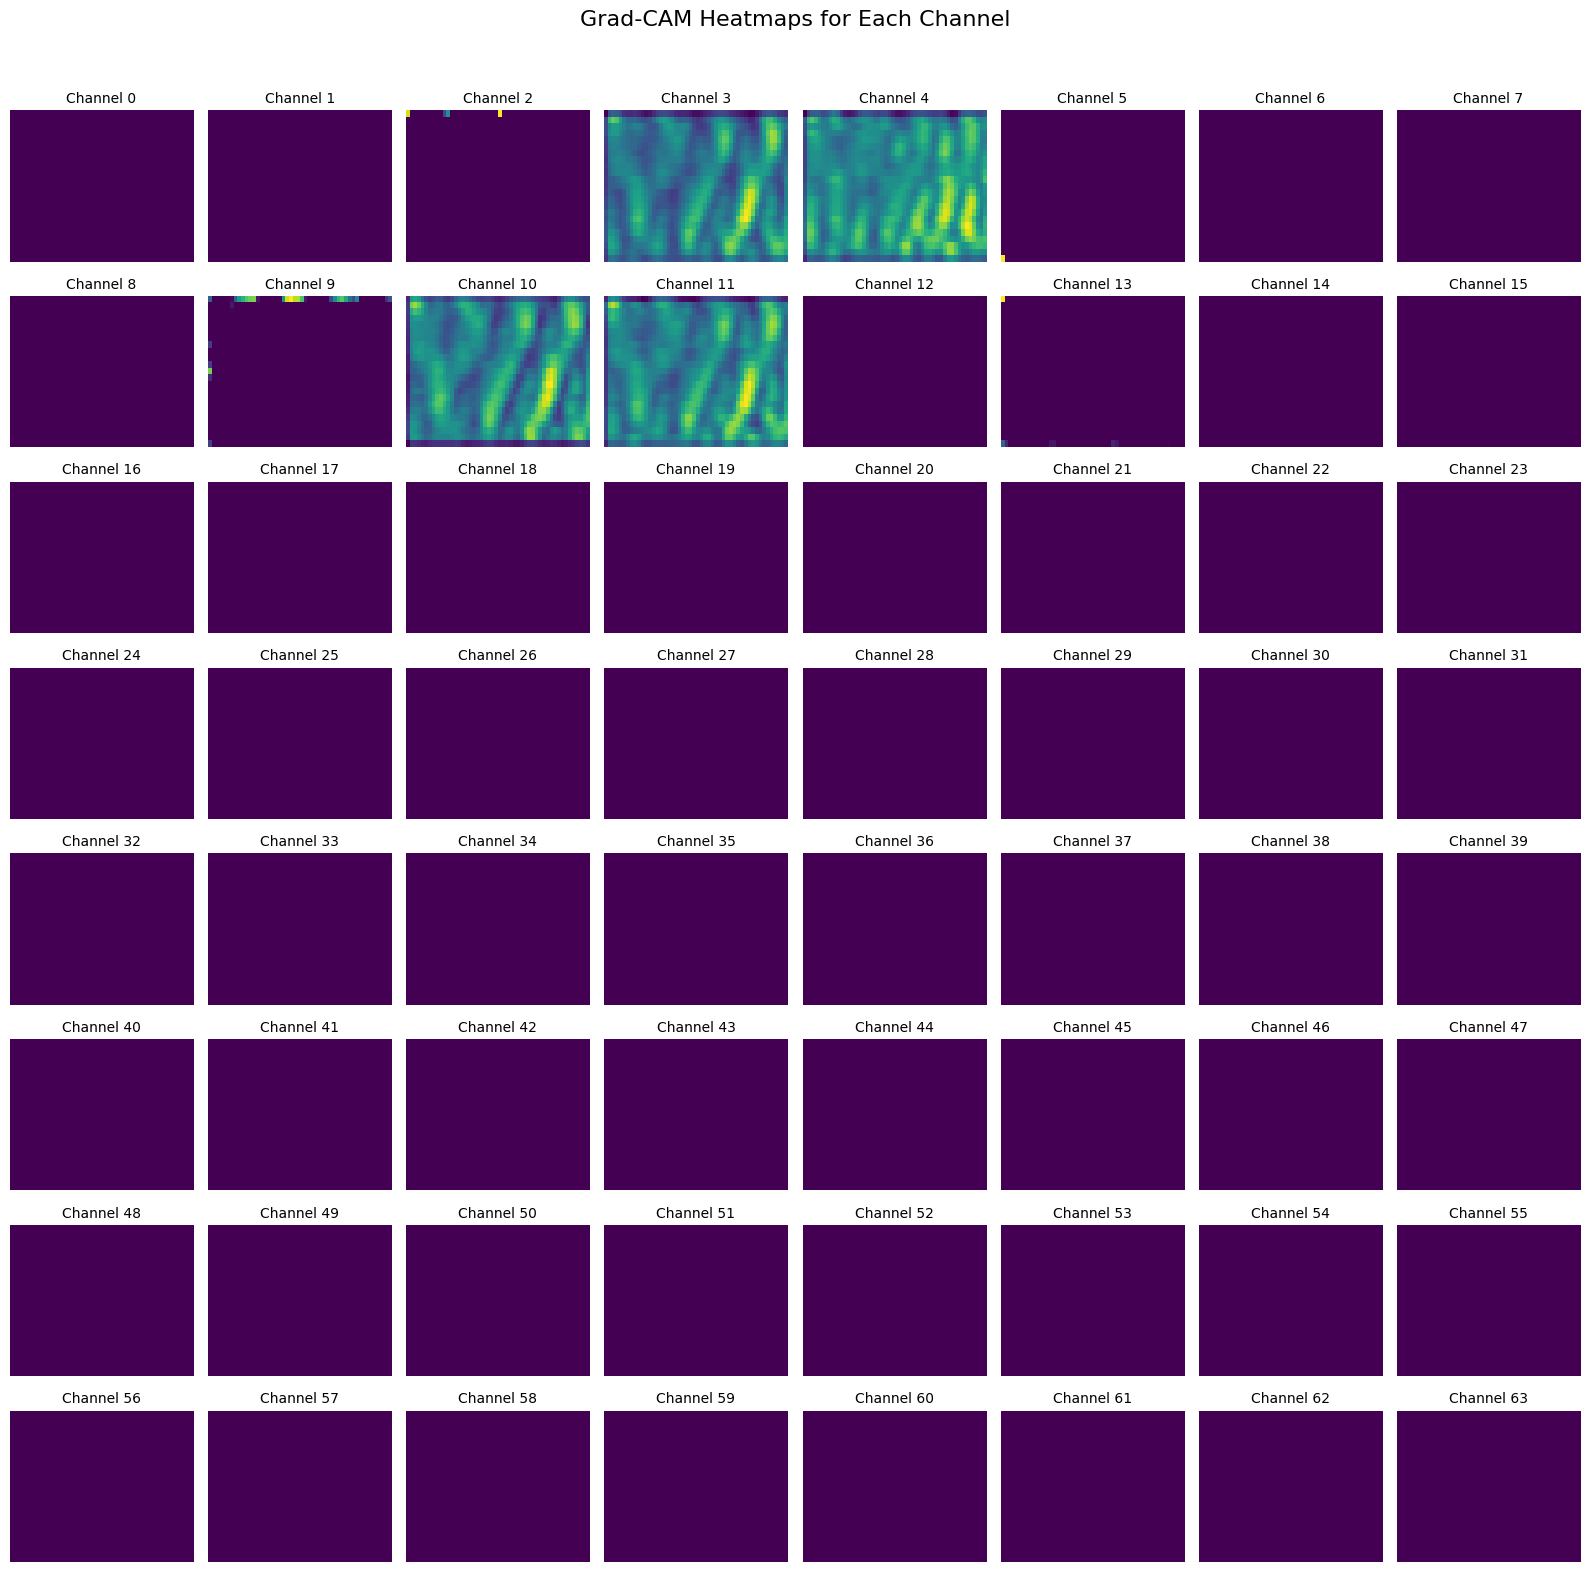

In [45]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Select a sample input from the validation dataset
sample_x, _ = val_dataset[0]  # Take the first example from validation set
sample_x = sample_x.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Hook to store gradients and activations
gradients = {}
activations = {}

def save_gradients(module, grad_in, grad_out):
    """Hook to save gradients from target layer."""
    gradients["value"] = grad_out[0]

def save_activations(module, input, output):
    """Hook to save activations from target layer."""
    activations["value"] = output

# Register hooks for the final convolutional layer (conv3 in the encoder)
encoder.conv3.register_forward_hook(save_activations)
encoder.conv3.register_backward_hook(save_gradients)

# Perform a forward pass to get the output (WITHOUT torch.no_grad())
autoencoder.eval()  # Set model to evaluation mode
output = autoencoder(sample_x)  # Forward pass without disabling gradients

# Compute the target loss (MSE for reconstruction)
loss = F.mse_loss(output, sample_x)

# Backward pass to compute gradients
autoencoder.zero_grad()  # Clear previous gradients
loss.backward()  # Compute gradients

# Get gradients and activations
grads = gradients["value"].cpu().numpy()[0]  # Gradients of shape [channels, depth, height, width]
acts = activations["value"].detach().cpu().numpy()[0]  # Activations of shape [channels, depth, height, width]

# Compute channel-wise weights using global average pooling of gradients
weights = np.mean(grads, axis=(1, 2, 3))  # Shape: [channels]

# Compute the Grad-CAM map per channel
grad_cam_per_channel = np.zeros_like(acts)  # Shape: [channels, depth, height, width]
for i, w in enumerate(weights):
    grad_cam_per_channel[i] = np.maximum(w * acts[i], 0)  # Weighted activation maps with ReLU

# Average over the time dimension (depth)
grad_cam_avg = np.mean(grad_cam_per_channel, axis=1)  # Shape: [channels, height, width]

# Normalize each channel's Grad-CAM map
grad_cam_avg_normalized = (grad_cam_avg - grad_cam_avg.min(axis=(1, 2), keepdims=True)) / (
    grad_cam_avg.max(axis=(1, 2), keepdims=True) - grad_cam_avg.min(axis=(1, 2), keepdims=True) + 1e-5
)

# Visualize Grad-CAM for each channel
n_channels = grad_cam_avg_normalized.shape[0]
n_cols = 8  # Number of columns in the grid
n_rows = (n_channels + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
fig.suptitle("Grad-CAM Heatmaps for Each Channel", fontsize=16)

for i in range(n_channels):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    ax.imshow(grad_cam_avg_normalized[i], cmap="viridis", aspect="auto")
    ax.set_title(f"Channel {i}", fontsize=10)
    ax.axis("off")

# Hide unused subplots
for i in range(n_channels, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
